In [1]:
# Quantium Virtual Internship – Task 2
# Experimentation and Uplift Testing

# 1. Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

plt.rcParams['figure.figsize'] = (10, 6)

C:\Users\das10\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 2. Load Data

data = pd.read_csv('QVI_data.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
# 3. Data Preparation

# Convert DATE column to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Create YEAR-MONTH field
data['YEARMONTH'] = data['DATE'].dt.to_period('M')

In [4]:
data.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09


In [5]:
# 4. Monthly Metrics per Store

monthly_metrics = (
    data.groupby(['STORE_NBR', 'YEARMONTH'])
    .agg(
        TOT_SALES=('TOT_SALES', 'sum'),
        TOTAL_CUSTOMERS=('LYLTY_CARD_NBR', 'nunique'),
        TRANSACTIONS=('TXN_ID', 'nunique')
    )
    .reset_index()
)

monthly_metrics['TXN_PER_CUST'] = (
    monthly_metrics['TRANSACTIONS'] / monthly_metrics['TOTAL_CUSTOMERS']
)

In [6]:
monthly_metrics.head(3)

,STORE_NBR,YEARMONTH,TOT_SALES,TOTAL_CUSTOMERS,TRANSACTIONS,TXN_PER_CUST
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847


In [7]:
# 5. Define Trial & Pre-Trial Periods

trial_stores = [77, 86, 88]

pre_trial = monthly_metrics[
    monthly_metrics['YEARMONTH'] < '2019-02'
]

trial_period = monthly_metrics[
    (monthly_metrics['YEARMONTH'] >= '2019-02') &
    (monthly_metrics['YEARMONTH'] <= '2019-04')
]

In [8]:
# 6. Control Store Selection Function

stores_with_trial_data = set(
    trial_period['STORE_NBR'].unique()
)

def calculate_similarity(trial_store, metric):
    trial_data = pre_trial[
        pre_trial['STORE_NBR'] == trial_store
    ]

    candidates = pre_trial[
        (~pre_trial['STORE_NBR'].isin(trial_stores)) &
        (pre_trial['STORE_NBR'].isin(stores_with_trial_data))
    ]

    correlations = {}

    for store in candidates['STORE_NBR'].unique():
        store_data = candidates[candidates['STORE_NBR'] == store]

        merged = trial_data.merge(
            store_data,
            on='YEARMONTH',
            suffixes=('_trial', '_control')
        )

        if len(merged) > 1:
            corr = merged[f'{metric}_trial'].corr(
                merged[f'{metric}_control']
            )
            correlations[store] = corr

    return max(correlations, key=correlations.get)

In [9]:
# 7. Select Control Stores

control_77 = calculate_similarity(77, 'TOT_SALES')
control_86 = calculate_similarity(86, 'TOT_SALES')
control_88 = calculate_similarity(88, 'TOT_SALES')

control_77, control_86, control_88

(71, 155, 159)

In [10]:
# 8. Scaling Control Stores

def scale_control(trial_store, control_store):
    trial_sum = pre_trial[
        pre_trial['STORE_NBR'] == trial_store
    ]['TOT_SALES'].sum()

    control_sum = pre_trial[
        pre_trial['STORE_NBR'] == control_store
    ]['TOT_SALES'].sum()

    return trial_sum / control_sum

In [11]:
# 9. Trial vs Control Comparison

def compare_trial_control(trial_store, control_store):
    scaling_factor = scale_control(trial_store, control_store)

    trial_data = trial_period[
        trial_period['STORE_NBR'] == trial_store
    ]

    control_data = trial_period[
        trial_period['STORE_NBR'] == control_store
    ].copy()

    control_data['SCALED_SALES'] = (
        control_data['TOT_SALES'] * scaling_factor
    )

    t_stat, p_value = ttest_ind(
        trial_data['TOT_SALES'],
        control_data['SCALED_SALES'],
        equal_var=False
    )

    return t_stat, p_value

In [12]:
# 10. Statistical Testing Results

results = {
    77: compare_trial_control(77, control_77),
    86: compare_trial_control(86, control_86),
    88: compare_trial_control(88, control_88)
}

results

{77: (-0.40779343585918426, 0.7090028683804612),
 86: (1.8758252008003824, 0.1628434262955986),
 88: (-1.3191653549849809, 0.3169738908253839)}

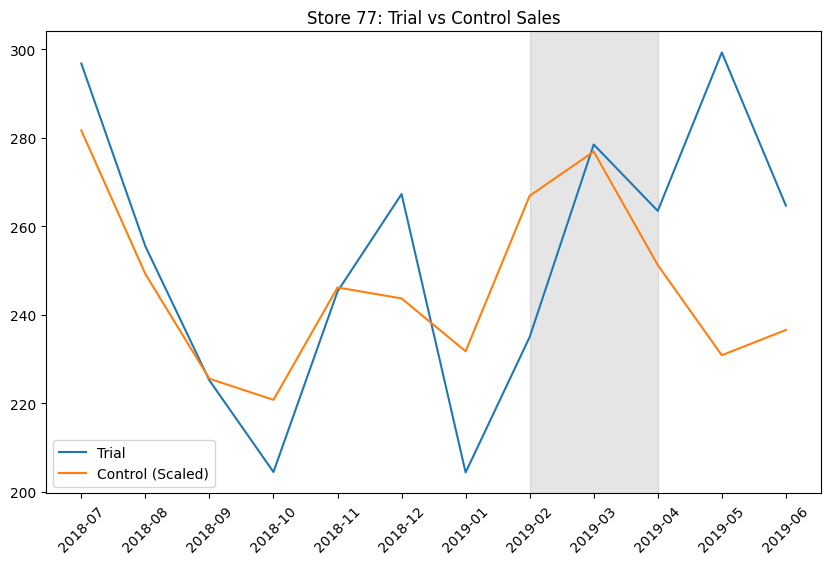

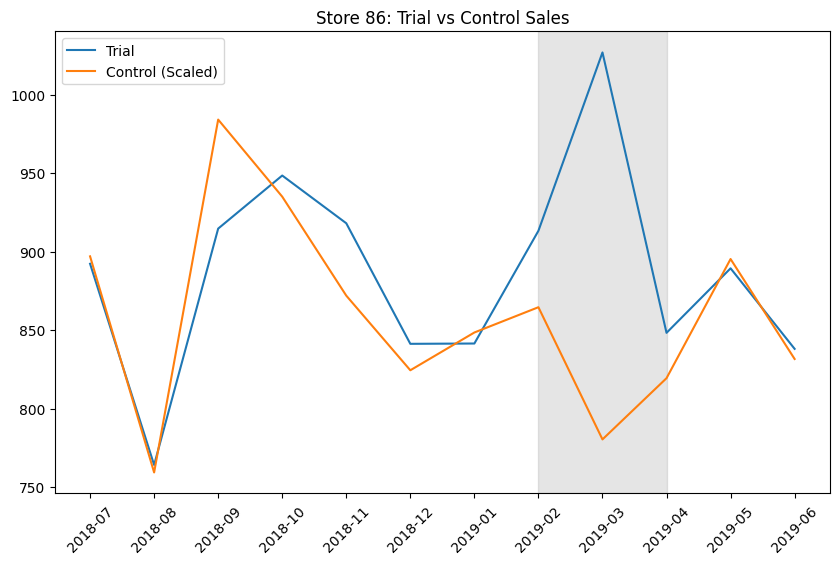

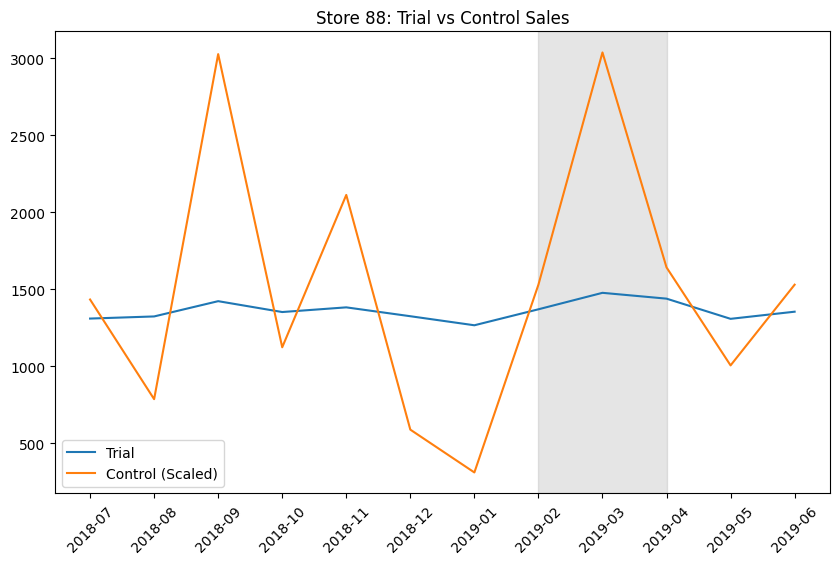

In [13]:
# 11. Visual Comparison

def plot_trial_vs_control(trial_store, control_store):
    scaling_factor = scale_control(trial_store, control_store)

    trial_data = monthly_metrics[
        monthly_metrics['STORE_NBR'] == trial_store
    ]

    control_data = monthly_metrics[
        monthly_metrics['STORE_NBR'] == control_store
    ].copy()

    control_data['SCALED_SALES'] = (
        control_data['TOT_SALES'] * scaling_factor
    )

    plt.plot(trial_data['YEARMONTH'].astype(str), trial_data['TOT_SALES'], label='Trial')
    plt.plot(control_data['YEARMONTH'].astype(str), control_data['SCALED_SALES'], label='Control (Scaled)')
    plt.axvspan('2019-02', '2019-04', color='grey', alpha=0.2)
    plt.title(f'Store {trial_store}: Trial vs Control Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_trial_vs_control(77, control_77)
plot_trial_vs_control(86, control_86)
plot_trial_vs_control(88, control_88)

In [14]:
# 12. Save Outputs

monthly_metrics.to_csv('QVI_Task2_Monthly_Metrics.csv', index=False)